<a href="https://colab.research.google.com/github/Ishita-Si/BlazeTrack/blob/main/transfer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ishitasingh09","key":"5ca2b12a0564f1b3b35c0c6b2160a760"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d phylake1337/fire-dataset
!unzip -q fire-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/phylake1337/fire-dataset
License(s): CC0-1.0
 97% 377M/387M [00:00<00:00, 426MB/s]
100% 387M/387M [00:00<00:00, 469MB/s]


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.6, 1.4)
)

In [5]:
train_gen = train_datagen.flow_from_directory(
    "fire_dataset/",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    "fire_dataset/",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 800 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit( train_gen,validation_data=val_gen,epochs=5)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8667 - loss: 0.3154 - val_accuracy: 0.4372 - val_loss: 5.8855
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9491 - loss: 0.2586 - val_accuracy: 0.8794 - val_loss: 1.0186
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9691 - loss: 0.0870 - val_accuracy: 0.6784 - val_loss: 2.5363
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9796 - loss: 0.0446 - val_accuracy: 0.5226 - val_loss: 4.1949
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9882 - loss: 0.0403 - val_accuracy: 0.7337 - val_loss: 2.7554


Text(0.5, 1.0, 'Training/Validation Accuracy')

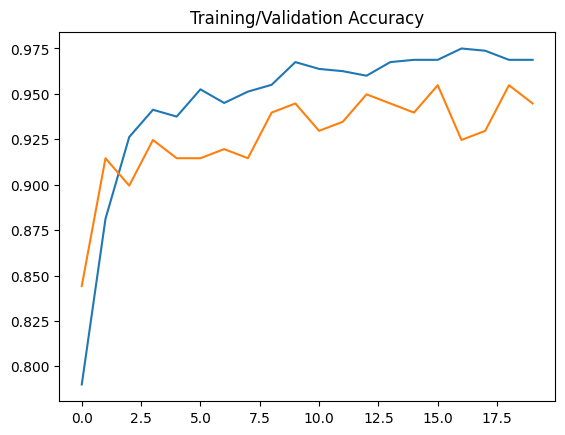

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
...
plt.title("Training/Validation Accuracy")


In [10]:
from sklearn.metrics import classification_report, confusion_matrix

val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = (preds > 0.5).astype(int)
y_true = val_gen.classes

print(classification_report(y_true, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 913ms/step
              precision    recall  f1-score   support

           0       0.73      0.76      0.75       151
           1       0.14      0.12      0.13        48

    accuracy                           0.61       199
   macro avg       0.44      0.44      0.44       199
weighted avg       0.59      0.61      0.60       199



In [24]:
from google.colab import files
uploaded = files.upload()

Saving Screenshot 2025-06-18 214135.png to Screenshot 2025-06-18 214135.png


In [12]:
train_gen.class_indices

{'fire_images': 0, 'non_fire_images': 1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
 Non Fire Images (Confidence: 0.57%)


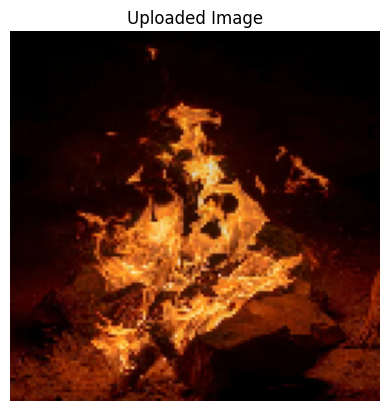

In [25]:
for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]

    class_map = train_gen.class_indices
    fire_label = min(class_map, key=class_map.get)
    non_fire_label = max(class_map, key=class_map.get)

    if prediction > 0.5:
        print(f" {fire_label.replace('_', ' ').title()} Detected (Confidence: {(1 - prediction) * 100:.2f}%)")
    else:
        print(f" {non_fire_label.replace('_', ' ').title()} (Confidence: {prediction * 100:.2f}%)")

    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()
